In [1]:
import pandas as pd
import numpy as np
import tpqoa
from typing import List, Tuple
import matplotlib.pyplot as plt
from Visualisation import plot_price_with_bands_and_signals, plot_cumulative_returns, plot_return_histogram, plot_zscore, plot_trade_context, plot_best_and_worst_trades


def get_data(instrument: str, start: str, end: str, granularity: str = "H1") -> pd.DataFrame:
    """
    Fetches historical price data from the OANDA API using tpqoa.
    Returns a DataFrame with close prices and log returns.
    """
    api = tpqoa.tpqoa("oanda.cfg")
    raw_data = api.get_history(instrument, start, end, granularity, price="M", localize=False)
    df = pd.DataFrame(raw_data["c"]).rename(columns={"c": "close"})
    df["returns"] = np.log(df["close"] / df["close"].shift(1))
    
    return df.dropna()


def calculate_bollinger_bands(data: pd.DataFrame, windows: List[int]) -> pd.DataFrame:
    """
    Adds Bollinger Band indicators (SMA, STD, Z-score) for given SMA windows to the DataFrame.
    """
    for window in windows:
        sma_col = f"SMA_{window}"
        std_col = f"STD_{window}"
        z_col = f"Z_{window}"

        data[sma_col] = data["close"].rolling(window=window).mean()
        data[std_col] = data["close"].rolling(window=window).std()
        data[z_col] = (data["close"] - data[sma_col]) / data[std_col]

    return data.dropna()

def bollinger_strategy(
    data: pd.DataFrame,
    settings: List[Tuple[int, float, float]],
) -> pd.DataFrame:
    """
    Computes entry and exit thresholds for a Bollinger Band-based strategy.
    Each setting is a tuple of (SMA window, entry threshold, exit threshold).
    SMA window: The length of the SMA window used. 
    entry threshold: The number of stds away from the SMA for a trade to be executed.
    exit threshold: The number of stds away from the SMA for a position to be closed.
    A position is opened when ALL settings give a buy or sell signal.
    A position is closed when SOME setting gives a neutral signal.
    """
    sma_windows = [s[0] for s in settings]
    data = calculate_bollinger_bands(data, sma_windows).copy()

    data.loc[:, "upper_entry_threshold"] = np.max([data[f"SMA_{s[0]}"] + s[1] * data[f"STD_{s[0]}"] for s in settings], axis=0)
    data.loc[:,"upper_exit_threshold"] = np.max([data[f"SMA_{s[0]}"] + s[2] * data[f"STD_{s[0]}"] for s in settings], axis=0)
    data.loc[:,"lower_entry_threshold"] = np.min([data[f"SMA_{s[0]}"] - s[1] * data[f"STD_{s[0]}"] for s in settings], axis=0)
    data.loc[:,"lower_exit_threshold"] = np.min([data[f"SMA_{s[0]}"] - s[2] * data[f"STD_{s[0]}"] for s in settings], axis=0)
        
    return data


def execute_trades(
    data: pd.DataFrame,
    reversion=True,
    restrict_hours=True
) -> pd.DataFrame:
    """
    Determines positions based on Bollinger entry/exit levels.
    Restrict hours: Only allow day trades and close any open positions at the day's close.
    """
    if restrict_hours:
        hours = data.index.hour
        data["is_daytime"] = ((hours < 20) | (hours > 23)).astype(int)
    else:
        data["is_daytime"] = [1]*len(data)  
    
    data["entry"]= (np.where(data["close"] > data["upper_entry_threshold"], 1, 0) + np.where(data["close"] < data["lower_entry_threshold"], -1, 0))
    data["last_entry"] = data["entry"].replace(0,np.nan).ffill().fillna(0)
    
    
    data["exit"] = np.where(data["close"] > data["lower_exit_threshold"], 2, 0)*np.where(data["last_entry"] == -1, 2, 0) + np.where(data["close"] < data["upper_exit_threshold"], 2, 0)*np.where(data["last_entry"] == 1, 2, 0)

    if reversion:
        sgn = -1
    else:
        sgn = 1    
    
    data["position"] = ((data["entry"] + data["exit"]).replace(0, np.nan).ffill().replace(3, 0).replace(4, 0).replace(5, 0)*sgn*data["is_daytime"]).fillna(0)

    return data


def apply_returns(data: pd.DataFrame, transaction_cost: float = 0.7, leverage: float = 1.0) -> pd.DataFrame:
    """
    Applies returns based on position, returns series, and transaction costs.
    Transaction costs should be given in pips.
    """
    data['trade_change'] = (data['position'] != data['position'].shift(1))
    data["transaction_cost"] = np.where(data["trade_change"], transaction_cost, 0) 
    data["profit"] = np.log((np.exp(data["position"]*data["returns"].shift(-1))-1- data["transaction_cost"]*0.0001)*leverage+1)
    
    data['trade_id'] = data['trade_change'].cumsum().where(data['position'] != 0, np.nan)
    realised_profit = data.groupby('trade_id')['profit'].sum()
    data['realised_profit'] = data['trade_id'].map(realised_profit).fillna(0)
    data['realised_profit'] = np.where(data['realised_profit'] != data['realised_profit'].shift(1), data['realised_profit'], 0)

    data["trade"] = np.where(data["position"] != data["position"].shift(1), data["position"] - data["position"].shift(1), 0)*leverage

    data["cumulative_profit"] = data["profit"].cumsum().shift(1).apply(np.exp)
    data["cumulative_price"] = data["returns"].cumsum().apply(np.exp)

    print(f"Total return: {np.round(data['cumulative_profit'].iloc[-1], 4)}\n")
    print(f"Number of trades: {int(np.sum(np.abs(data['trade'])))}")

    return data

def test_strategy(
    data: pd.DataFrame,
    settings: List[Tuple[int, float, float]],
    transaction_cost: float = 0.7,
    leverage: float = 1.0,
    reversion=True,
    restrict_hours=False,
    plots=True
):

    data = bollinger_strategy(data, settings)
    data = execute_trades(data, reversion=reversion, restrict_hours=restrict_hours)
    data = apply_returns(data, leverage=leverage, transaction_cost=transaction_cost)
    

    zscore_cols = [f"Z_{s[0]}" for s in settings]  

    if plots:
        plot_cumulative_returns(data)
        plot_price_with_bands_and_signals(data)
        plot_return_histogram(data)
        plot_zscore(data, zscore_cols, [s[1] for s in settings]) 
        plot_best_and_worst_trades(data)

    return np.round(data['cumulative_profit'].iloc[-1], 4)

In [2]:
"""Example usage"""

# Parameters
instrument = "EUR_USD"
start = "2020-01-01"
end = "2022-01-01"
granularity = "H1"

data = get_data(instrument, start, end, granularity)

Total return: 0.9243

Number of trades: 930


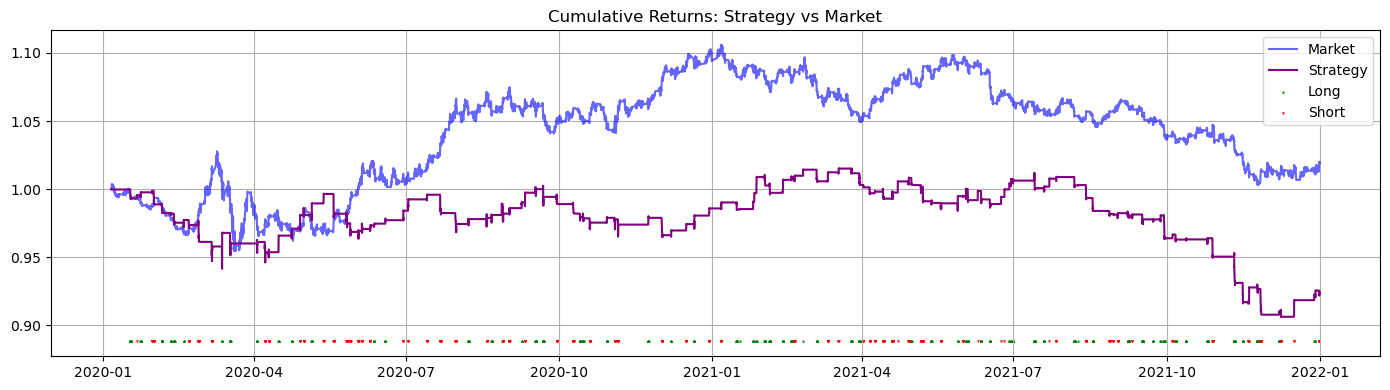

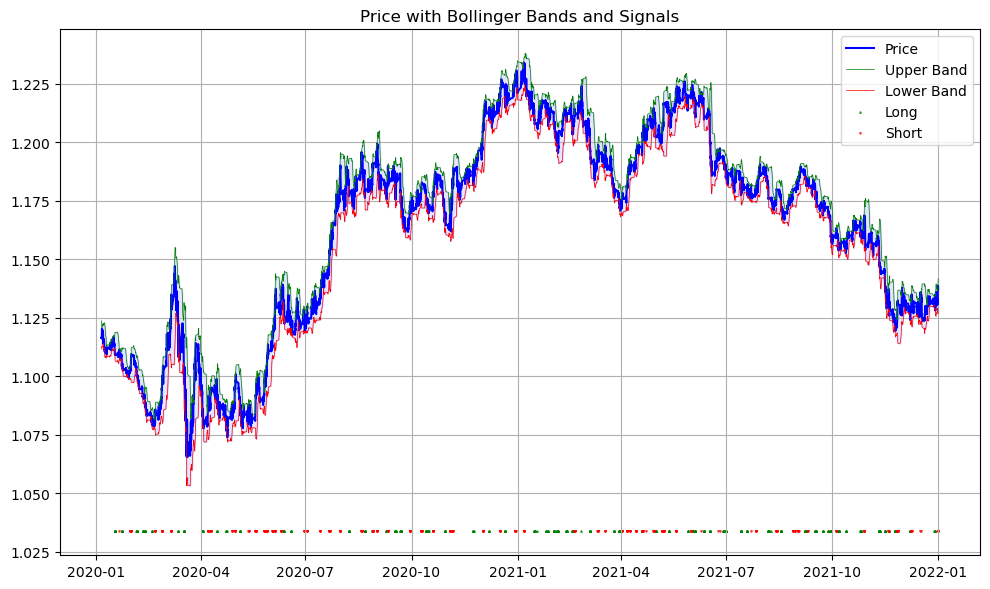

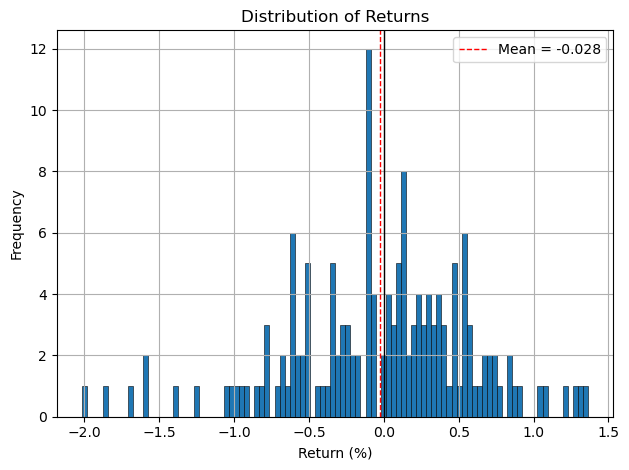

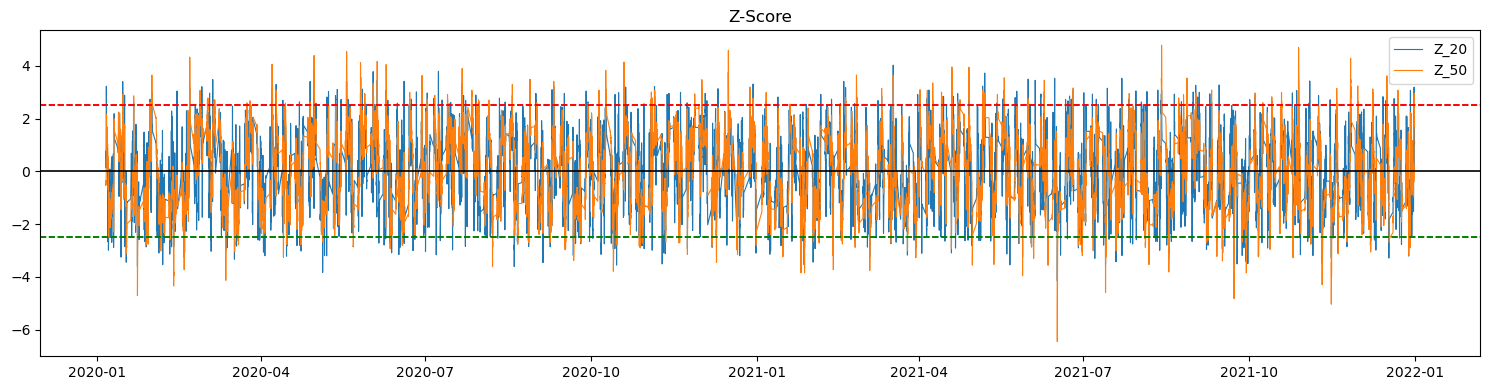

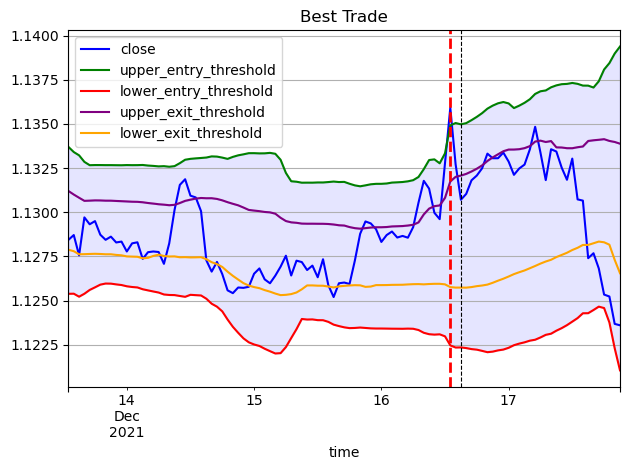

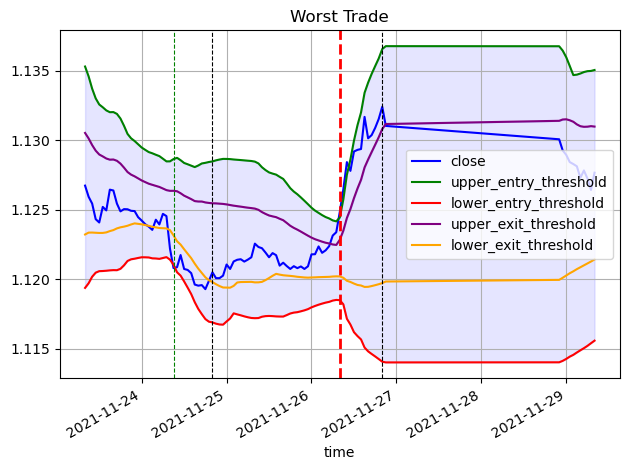

0.9243

In [3]:
tc = 0.7
leverage = 3
settings = [(20, 2.5, 1), (50, 2.5, 1)]

test_strategy(data, settings, transaction_cost=tc, leverage=leverage, reversion=True, restrict_hours=True, plots=True)